**Chapter 18 – Reinforcement Learning**

_This notebook contains all the sample code in chapter 18_.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the
figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we
strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Introduction to OpenAI gym

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing
 Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with.
 Let's start by importing `gym`:

In [2]:
!pip install gym

In [3]:
import gym

Let's list all the available environments:

In [4]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically
on top of it. The agent must move the cart left or right to keep the pole upright.

In [5]:
env = gym.make('CartPole-v1')

Let's initialize the environment by calling is `reset()` method. This returns an observation:

In [6]:
env.seed(42)
obs = env.reset()

Observations vary depending on the environment. In this case it is a 1D NumPy array composed of 4 floats: they
represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

In [7]:
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

An environment can be visualized by calling its `render()` method, and you can pick the rendering mode (the rendering
options depend on the environment).

**Warning**: some environments (including the Cart-Pole) require access to your display, which opens up a separate
window, even if you specify `mode="rgb_array"`. In general you can safely ignore that window. However, if Jupyter is
 running on a headless server (ie. without a screen) it will raise an exception. One way to avoid this is to install
 a fake X server like [Xvfb](http://en.wikipedia.org/wiki/Xvfb). On Debian or Ubuntu:

```bash
$ apt update
$ apt install -y xvfb
```

You can then start Jupyter using the `xvfb-run` command:

```bash
$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook
```

Alternatively, you can install the [pyvirtualdisplay](https://github.com/ponty/pyvirtualdisplay) Python library
which wraps Xvfb:

```bash
python3 -m pip install -U pyvirtualdisplay
```

And run the following code:

In [8]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [9]:
env.render()

True

In this example we will set `mode="rgb_array"` to get an image of the environment as a NumPy array:

In [10]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [11]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

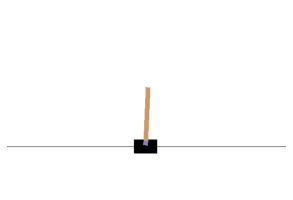

In [12]:
plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the
set of possible actions). Let's see what this environment's action space looks like:

In [13]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left or towards the right.

Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

In [14]:
action = 1  # accelerate right
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the
right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward
the left after the next step.

Saving figure cart_pole_plot


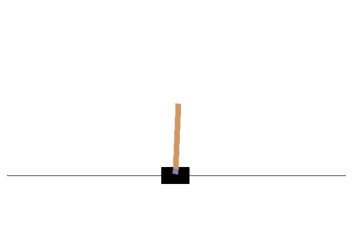

In [15]:
plot_environment(env)
save_fig("cart_pole_plot")

Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [16]:
reward

1.0

When the game is over, the environment returns `done=True`:

In [17]:
done

False

Finally, `info` is an environment-specific dictionary that can provide some extra information that you may find
useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [18]:
info

{}

The sequence of steps between the moment the environment is reset until it is done is called an "episode". At the
end of an episode (i.e., when `step()` returns `done=True`), you should reset the environment before you continue
to use it.

In [19]:
if done:
    obs = env.reset()

Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy
that the agent will use to select an action at each step. It can use all the past actions and observations to
decide what to do.

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and
_vice versa_. Let's see if that works:

In [20]:
env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [21]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 68 steps.
This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode:

In [22]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

Now show the animation:

In [23]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [24]:
plot_animation(frames)

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need
to be smarter than that!

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the action to take for each
observation. To choose an action, the network will estimate a probability for each action, then we will select
an action randomly according to the estimated probabilities. In the case of the Cart-Pole environment, there are
just two possible actions (left or right), so we only need one output neuron: it will output the probability `p`
of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In this particular environment, the past actions and observations can safely be ignored, since each observation
contains the environment's full state. If there were some hidden state then you may need to consider past actions
and observations in order to try to infer the hidden state of the environment. For example, if the environment
only revealed the position of the cart but not its velocity, you would have to consider not only the current
observation but also the previous observation in order to estimate the current velocity. Another example is if
the observations are noisy: you may want to use the past few observations to estimate the most likely current
state. Our problem is thus as simple as can be: the current observation is noise-free and contains the
environment's full state.

You may wonder why we plan to pick a random action based on the probability given by the policy network, rather
than just picking the action with the highest probability. This approach lets the agent find the right balance
between _exploring_ new actions and _exploiting_ the actions that are known to work well. Here's an analogy: suppose
you go to a restaurant for the first time, and all the dishes look equally appealing, so you randomly pick one.
If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase
that probability to 100%, or else you will never try out the other dishes, some of which may be even better than
the one you tried.

Let's write a small function that will run the model to play one episode, and return the frames, so we can display
an animation:

In [26]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()

    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

Now let's look at how well this randomly initialized policy network performs:

In [27]:
frames = render_policy_net(model)
plot_animation(frames)

Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning
the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

We can make the same net play in 50 different environments in parallel (this will give us a diverse training batch
at each step), and train for 5000 iterations. We also reset environments when they are done. We train the model
using a custom training loop, so we can easily use the predictions at each training step to advance the environments.

In [28]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]

for index, env in enumerate(envs):
    env.seed(index)

np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))

    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)

    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.094

In [29]:
# ToDO: Fix Crash on Windows
# frames = render_policy_net(model)
# plot_animation(frames)

Looks like it learned the policy correctly. Now let's see if it can learn a better policy on its own. One that does
not wobble as much.

# Policy Gradients

To train this neural network we will need to define the target probabilities `y`. If an action is good we should
increase its probability, and conversely if it is bad we should reduce it. But, how do we know whether an action
is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in an
episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10?
Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple episodes, then making the actions
in good episodes slightly more likely, while actions in bad episodes are made slightly less likely. First we
play, then we go back and think about what we did.

Let's start by creating a function to play a single step using the model. We will also pretend for now that
whatever action it takes is the right one, so we can compute the loss and its gradients (we will just save these
gradients for now, and modify them later depending on how good or bad the action turned out to be):

In [30]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformly sampled
between 0 and 1 will probably not be greater than `left_proba`). And, `False` means 0 when you cast it to a number,
so `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the
probability of going left should have been 100% (so we took the right action).

Now let's create another function that will rely on the `play_one_step()` function to play multiple episodes,
returning all the rewards and gradients, for each episode and each step:

In [31]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back
and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the
first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [32]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

# Normalize the discounted rewards across many episodes
# TODO: Apply Bayesian V.I here, with a Gaussian or Mat* Kernel
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount
factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only
get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the
first reward (+10), which leads to a discounted reward of -22:

In [33]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the
discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [34]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [35]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [36]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [37]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [38]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update,
        n_max_steps, model, loss_fn
    )

    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book

    print("\rIteration: {}, mean rewards: {:.1f}"
          .format(iteration, total_rewards / n_episodes_per_update), end="") # Not shown

    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    all_mean_grads = []

    # ToDo: Causal Inference, take Deepmind's ICML paper
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]       # episode
             for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)]
            , axis=0
        )
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))   # Return or iteration

env.close()

Iteration: 149, mean rewards: 199.6

Exception ignored in: <function Viewer.__del__ at 0x0000019024A79310>
Traceback (most recent call last):
  File "C:\Users\mayan\anaconda3\envs\tf\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "C:\Users\mayan\anaconda3\envs\tf\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\mayan\anaconda3\envs\tf\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\mayan\anaconda3\envs\tf\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\mayan\anaconda3\envs\tf\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x0000019085713720; to 'Win32Window' at 0x00000190210D4550>


In [39]:
frames = render_policy_net(model)
plot_animation(frames)

# Markov Chains

In [40]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']        # Figure: 18-7
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


# Markov Decision Process

Let's define some transition probabilities, rewards and possible actions. For example, in state s0, if action a0 is
chosen then with probability 0.7 we will go to state s0 with reward +10, with probability 0.3 we will go to
state s1 with no reward, and with never go to state s2 (so the transition probabilities are `[0.7, 0.3, 0.0]`, and
the rewards are `[+10, 0, 0]`):

In [41]:
transition_probabilities = [ # shape=[s, a, s']     # Figure: 18-8
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]
]

rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]

possible_actions = [[0, 1, 2], [0, 2], [1]]

# Q-Value Iteration

In [42]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions

for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [43]:
gamma = 0.90  # the discount factor

history1 = [] # Not shown in the book (for the figure below)

for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)
            ])

history1 = np.array(history1) # Not shown

In [44]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [45]:
np.argmax(Q_values, axis=1)

array([0, 0, 1], dtype=int64)

The optimal policy for this MDP, when using a discount factor of 0.90, is to choose action a0 when in state s0, and
choose action a0 when in state s1, and finally choose action a1 (the only possible action) when in state s2.

### Let's try again with a discount factor of 0.95:

In [46]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [47]:
gamma = 0.95  # the discount factor

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)]
            )

In [48]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [49]:
np.argmax(Q_values, axis=1)

array([0, 2, 1], dtype=int64)

Now the policy has changed! In state s1, we now prefer to go through the fire (choose action a2). This is because
the discount factor is larger, so the agent values the future more, and it is therefore ready to pay an immediate
penalty in order to get more future rewards.

# Q-Learning

Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values.
Once it has accurate Q-Value estimates (or close enough), then the optimal policy consists in choosing the action
that has the highest Q-Value (i.e., the greedy policy).

We will need to simulate an agent moving around in the environment, so let's define a function to perform some
action and get the new state and a reward:

In [50]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

We also need an exploration policy, which can be any policy, as long as it visits every possible state many times.
We will just use a random policy, since the state space is very small:

In [51]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

Now let's initialize the Q-Values like earlier, and run the Q-Learning algorithm:

In [52]:
np.random.seed(42)

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = [] # Not shown in the book

for iteration in range(10000):
    history2.append(Q_values.copy()) # Not shown
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha      # Equation 18.4 (TD)
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # Not shown

In [53]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [54]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1], dtype=int64)

This algorithm will converge to the optimal Q-Values, but it will take many iterations, and possibly quite a lot of hyperparameter tuning. As you can see in Figure 18-9, the Q-Value Iteration algorithm (left) converges very quickly, in fewer than 20 iterations, while the Q-Learning algorithm (right) takes about 8,000 iterations to converge. Obviously, not knowing the transition probabilities or the rewards makes finding the optimal policy significantly harder!

Saving figure q_value_plot


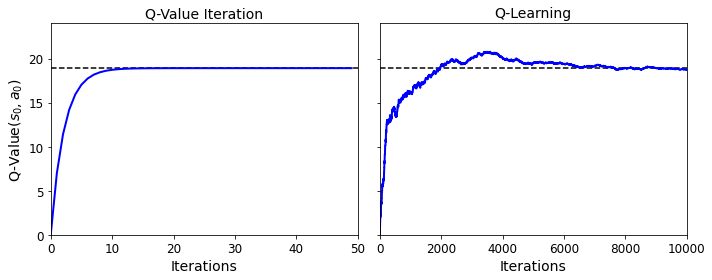

In [55]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

save_fig("q_value_plot")

# Deep Q-Network

Let's build the DQN. Given a state, it will estimate, for each possible action, the sum of discounted future rewards
it can expect after it plays that action (but before it sees its outcome):

In [56]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure 
that the agent explores the environment, we choose a random action with probability `epsilon`.

In [57]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

We will also need a replay memory. It will contain the agent's experiences, in the form of tuples: 
`(obs, action, reward, next_obs, done)`. We can use the `deque` class for that:

In [58]:
from collections import deque

replay_memory = deque(maxlen=2000)

And, let's create a function to sample experiences from the replay memory. It will return 5 NumPy arrays:
`[obs, actions, rewards, next_obs, dones]`.

In [59]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

Now we can create a function that will use the DQN to play one step, and record its experience in the replay memory:

In [60]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

Lastly, let's create a function that will sample some experiences from the replay memory and perform a training step:

**Note**: the first 3 releases of the 2nd edition were missing the `reshape()` operation which converts 
`target_Q_values` to a column vector (this is required by the `loss_fn()`).

In [61]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    # print(f"Before reshaping target_Q_values: {target_Q_values.shape}")
    target_Q_values = target_Q_values.reshape(-1, 1)
    # print(f"After reshaping target_Q_values: {target_Q_values.shape}")
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

And, now, let's train the model!

In [62]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

In [63]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step > best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 599, Steps: 19, eps: 0.0108

Saving figure dqn_rewards_plot


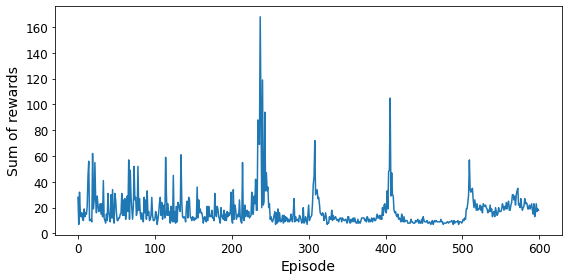

In [64]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

In [65]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

Not bad at all!

## Double DQN

In [66]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [67]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [68]:
replay_memory = deque(maxlen=2000)

In [69]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    if episode % 50 == 0:
        target.set_weights(model.get_weights())
    # Alternatively, you can do soft updates at each step:
    #if episode > 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights)

Episode: 599, Steps: 49, eps: 0.0100

Saving figure double_dqn_rewards_plot


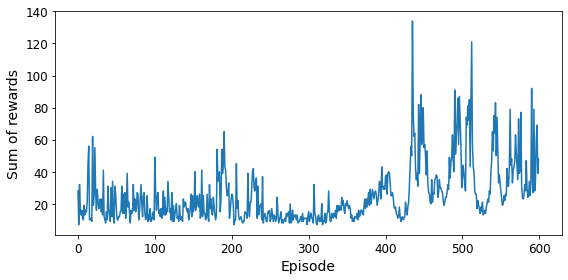

In [70]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("double_dqn_rewards_plot")
plt.show()

In [71]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

# Dueling Double DQN

In [72]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [73]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-2)
loss_fn = keras.losses.Huber()

# https://davidsanwald.github.io/2016/12/11/Double-DQN-interfacing-OpenAi-Gym.html

# Rainbow: Combining improvements in deep reinforcement learning
# https://arxiv.org/abs/1710.02298
# https://github.com/Kaixhin/Rainbow

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [74]:
replay_memory = deque(maxlen=2000)

In [75]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    if episode % 200 == 0:
        target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 599, Steps: 74, eps: 0.0100

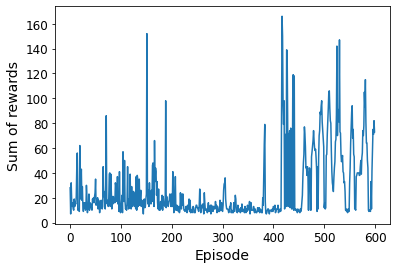

In [76]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [77]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

This looks like a pretty robust agent!

In [78]:
env.close()